## Imports

In [12]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x_ = frank_object._FT._x*rad_to_arcsec
    y_ = frank_object._FT._y*rad_to_arcsec
    x, y = np.meshgrid(x_, y_, indexing='ij')
    pixel_size = (x[1]-x[0])[0]
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u_ = frank_object._FT._u
    v_ = frank_object._FT._v
    u, v = np.meshgrid(u_, v_, indexing='ij')
    pixel_size = (u[1]-u[0])[0]
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_binned

### Data

In [6]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 3 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [7]:
l = 1e4
m = -0.33
c = -0.1
N = 300

In [8]:
frank2d = Frank2D(N, Rout)
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-7')

Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:44: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.01  min |  0.43 seconds
Setting fit with cg ...
Fitting...
  *  Constructing linear operators...
     --> time = 17.81  min |  1068.43 seconds
  *  Solving linear system...
rtol:  1e-7
atol:  0.0
rtol:  0.17753780138460917
final atol:  0.17753780138460917
maxiter:  20
iteration:  0
iteration:  1
  --> CGM converged in  1  iterations
     --> time = 14.71  min |  882.35 seconds
  --> CGM converged?   True
  --> Fit correctly?   False
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


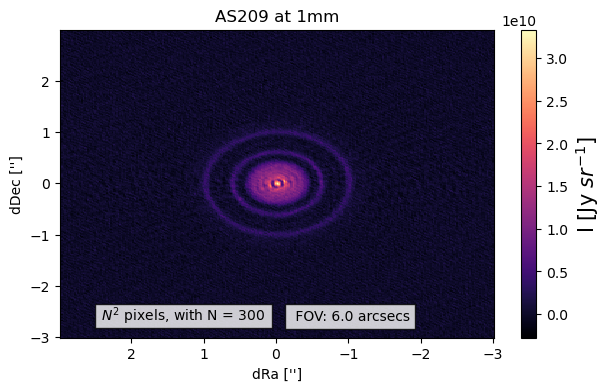

In [9]:
Plot(frank2d).get_image('AS209 at 1mm')

In [10]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

In [13]:
r, I = get_radial_profile(frank2d)

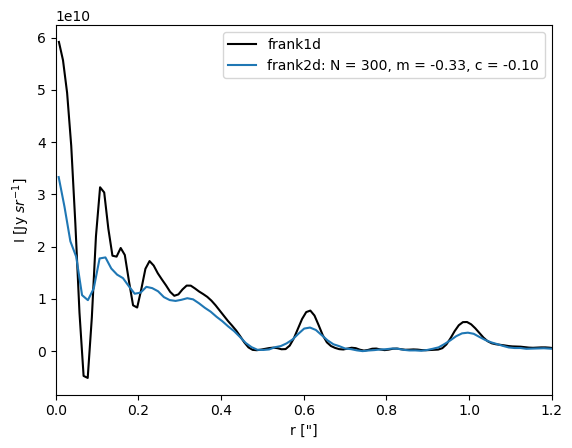

In [14]:
plt.plot(sol.r, sol.mean, 'black',label ='frank1d')
plt.plot(r, I, label = f'frank2d: N = {N}, m = {m:.2f}, c = {c:.2f}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']
weights_gridded = frank2d._gridded_data['weights']
baselines_gridded = np.hypot(u_gridded, v_gridded)
binned_vis_gridded = UVDataBinner(baselines_gridded, vis_gridded, np.ones_like(weights_gridded), bin_widths[1])
#plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None')

vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

q, Vis = get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis.real), label = f'frank2d: N = 200')#, m = {m:.2f}, c = {c:.2f}')

q_2, Vis_2 = get_vis_profile(frank2d_2)
plt.plot(q_2, Vis_2.real, label = f'frank2d: N = 100, m = {m:.2f}, c = {c:.2f}')
plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None')

plt.xlabel(r'q [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 0.1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()